### Tasks - project 4

Identifying regulatory interactions
Single cell RNA sequencing data allows the measurement of all genes in many cells at the same time. Genes are often co-regulated, or regulate each other. Correlation, anti-correlation or mutual information between pairs of genes can hint regulatory interactions, and help in reconstructing regulatory networks.

*	Background single cell RNA sequencing
*	Data – any single cell RNA-sequencing data.
*	Filter out genes that are not expressed
*	Replace values lower than one by one. log2 transform the data
*	Identify pairs of genes that are significantly correlated (alternatively, anti-correlated or have mutual information). Take into account the problem of multiple comparisons
*	Test if those gene pairs are also correlated in the other dataset. 
*	For at least one correlated pair of genes, see if you can find research about interaction or functional relationships between those genes. 


# The Libraries

In [1]:
from sys import getsizeof
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mutual_info_score
from scipy.stats.stats import pearsonr   
import matplotlib.pyplot as plt
%matplotlib inline




# Functions

In [2]:
def calc_MI(x, y, bins=12):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi


def mutual_info_per_df(df, nbins):
    mi_genes = {}
    for i, gen1 in enumerate(df):
        for j, gen2 in enumerate(df):
            if j >= i:
                continue
            val = calc_MI(df[gen1].values.astype(dtype='float'),
                          df[gen2].values.astype(dtype='float'),
                                                   bins=12)
            mi_genes['__'.join([gen1, gen2])] = val
        if i % 40 == 0: print i
    print np.mean(mi_corr.values()), np.std(mi_corr.values())
    return mi_genes


def pre_log2(df):
    for gene in df:
        for ind, val in df[gene].iteritems():
            if val <= 1:
                df.set_value(index=ind, col=gene, value=0)
            elif val > 1:
                df.set_value(index=ind, col=gene, value=np.log2(val))
    return df

def remove_zero_genes(mode, trsh=40):
    cnt = 0
    zeros = []
    for col in tqdm(df):
        if mode == 'zero':
            if (df[col].values < 1).all():
                cnt += 1
                zeros.append(col)            
        elif mode == 'sparse':
            if np.sum((df[col].values > 1)) < 40:        
                cnt += 1
                zeros.append(col)
    print '# removed columns = ', cnt
    df.drop(zeros, axis=1, inplace=True)
    return df

In [3]:
x, y = range(1000), range(1000)

calc_MI(x, y, 10)

2.302585092994045

In [4]:
calc_MI(range(20), 2*np.arange(20))

2.4412145291060345

In [5]:
% ls data/

GSE81383_data_melanoma_scRNAseq_BT_Mel.txt
GSE82187_cast_all_forGEO.csv
GSE83533_AML_130_Rel_rpkm.txt
unused/


In [6]:
!du -h data/GSE83533_AML_130_Rel_rpkm.txt

9.1M	data/GSE83533_AML_130_Rel_rpkm.txt


# Reading the data

In [7]:
path = '/Users/mdymshits/comp_bio/data/GSE83533_AML_130_Rel_rpkm.txt'
df = pd.read_csv(path, delimiter='\t')

## Small preprocessing:
### like transpose 
### removing some headers
### issue with duplicate genes

In [8]:
df = df.iloc[:, 1:].T
df.columns = df.iloc[0]
df = df.reindex(df.index.drop('gene'))
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.columns = ['_'.join([col, str(i)]) for i, col in enumerate(df.columns)]
df.iloc[:10,:10]

,TAF1L_0,RNU6-69_1,ROCK1_2,SNORD115-42_3,OR8B2_4,LYN_5,SNORD115-43_6,OR8B3_7,OR2AT4_8,KCTD14_9
0,0,0,40.0059,0,0,4.95385,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,70.5803,0,0,2.86212,0,0,0,0
3,0,0,24.1233,0,0,144.22,0,0,0,0
4,0,0,2.9105,0,0,0.665994,0,0,0,0
5,0,0,0.0638631,0,0,0,0,0,0,0
6,0,0,29.135,0,0,0,0,0,0,0
7,0,0,80.7414,0,0,0,0,0,0,0
8,0,0,22.4341,0,0,1.01223,0,0,0,0
9,0,0,11.2208,0,0,6.37025,0,0,0,0


(0, 25000)

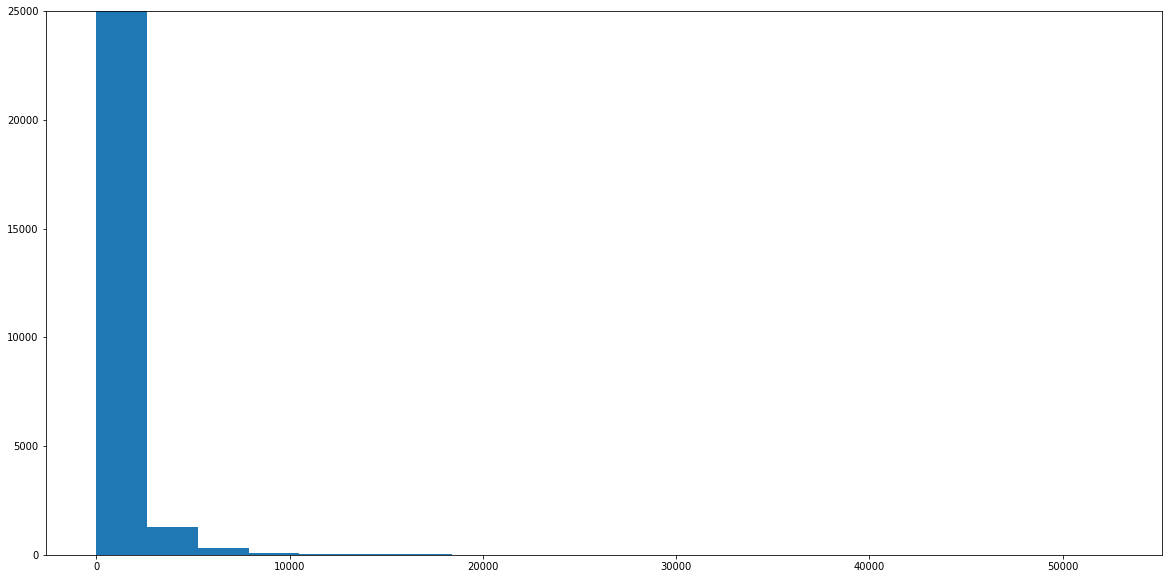

In [9]:
plt.figure(figsize=(20, 10))
# bins = np.linspace(0, .25, 20)
plt.hist(df.values.ravel(), bins=20);
# plt.xlim(0, 20)
plt.ylim(0, 25000)


In [10]:
df.shape

(96, 23737)

# Preprocessing with $log_2$

In [11]:
%time df = pre_log2(df)
           

CPU times: user 11.5 s, sys: 198 ms, total: 11.7 s
Wall time: 11.6 s


23737it [00:00, 43858.25it/s]         


# removed columns =  22843


(0, 20000)

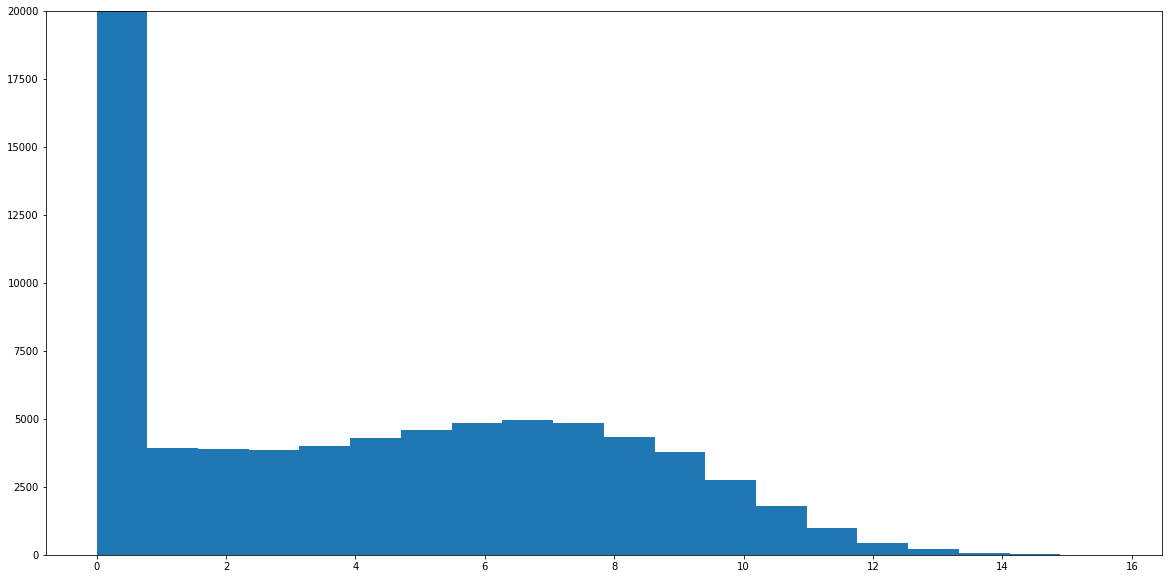

In [12]:
df = remove_zero_genes(mode='sparse')
col_names = df.columns
plt.figure(figsize=(20, 10))
plt.hist(df.values.ravel(), bins=20);
plt.ylim(0, 20000)


In [13]:
df.shape

(96, 894)

# Claculation of correlation coefficient

In [14]:
%%time
cor = np.corrcoef(df.values.astype(dtype='float').T)

CPU times: user 12.9 ms, sys: 2.99 ms, total: 15.9 ms
Wall time: 11.5 ms


In [15]:
cor.shape

(894, 894)

# Look up for genes with correlation above $0.9$

In [16]:
cor_genes = {}
for i in tqdm(range(cor.shape[0])):
    for j in range(cor.shape[0]):
        if j >= i:
            continue
        if abs(cor[i,j]) > .85:
            cor_genes['__'.join([col_names[i], col_names[j]])] = cor[i,j]
#             print cor[i,j], col_names[i], col_names[j]

100%|██████████| 894/894 [00:00<00:00, 2995.23it/s]


In [17]:
len(cor_genes)

7

In [18]:
# 

In [19]:
cor_genes

{'HSP90AB1_20398__HSP90AB3P_19467': 0.88020268437348059,
 'MTRNR2L1_22884__MTRNR2L2_6347': 0.92660197099608821,
 'MTRNR2L2_6347__MTRNR2L8_2970': 0.8952883662019967,
 'MTRNR2L6_5103__MTRNR2L8_2970': 0.87976429586632554,
 'NACA2_16179__NACA_6238': 0.93002162024969215,
 'PABPC1_15668__PABPC3_14723': 0.87248501550942215,
 'RPL23P8_22973__RPL23_1895': 0.90667917617854832}

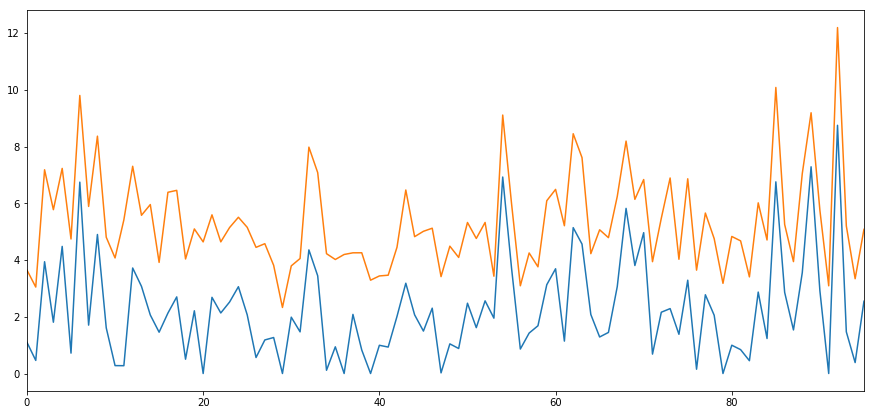

In [20]:
df['MTRNR2L1_22884'].multiply(1).plot(figsize=(15,7));
df['MTRNR2L2_6347'].plot(figsize=(15,7));

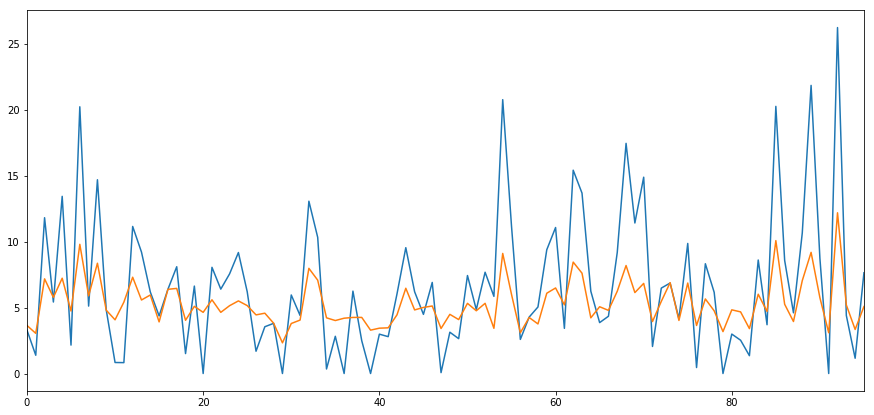

In [21]:
df['MTRNR2L1_22884'].multiply(3).plot(figsize=(15,7));
df['MTRNR2L2_6347'].plot(figsize=(15,7));

In [22]:
non_cor_genes = {}
for i in tqdm(range(cor.shape[0])):
    for j in range(cor.shape[0]):
        if j >= i:
            continue
        if abs(cor[i,j]) < .01:
            non_cor_genes['__'.join([col_names[i], col_names[j]])] = cor[i,j]


100%|██████████| 894/894 [00:00<00:00, 2529.68it/s]


In [23]:
len(non_cor_genes) / 10. ** 3

24.58

## Calculating Mutual Information for Gens with corelation

### $H(X|Y) 	= -\sum_{x,y} p(x,y) \log \frac{p(x,y)}{p(y)} $

In [24]:
nbins = 25
mi_no_corr = []
for i, key in enumerate(non_cor_genes):
    gen1, gen2 = key.split('__')
#     print gen1, gen2
    val = calc_MI(df[gen1].values.astype(dtype='float'),
                  df[gen2].values.astype(dtype='float'),
                                             bins=nbins)
    mi_no_corr.append(val)
print np.mean(mi_no_corr), np.std(mi_no_corr)   

0.995133462349 0.190756199402


## Calculating Mutual Information for genes without corelation

In [25]:
n_bins=100
mi_corr = {}
for i, key in enumerate(cor_genes):
    gen1, gen2 = key.split('__')
    val = calc_MI(df[gen1].values.astype(dtype='float'),
                  df[gen2].values.astype(dtype='float'),
                                            bins=nbins)
    mi_corr['__'.join([gen1, gen2])] = val

print np.mean(mi_corr.values()), np.std(mi_corr.values())


1.51970916575 0.185517494397


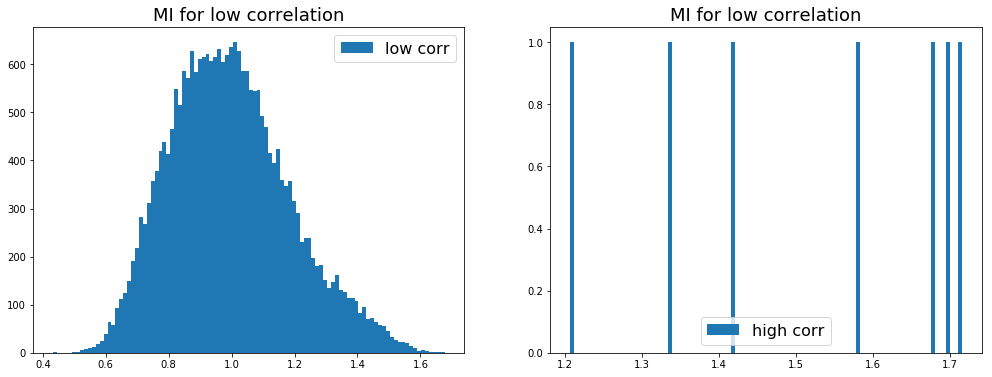

In [31]:
plt.figure(figsize=(17, 6))
plt.subplot(1,2,1)
plt.hist(mi_no_corr, bins= 100, label='low corr');
plt.legend(fontsize=16)
plt.title('MI for low correlation', fontsize=18)
plt.subplot(1,2,2)
plt.hist(mi_corr.values(), bins=100, label='high corr');
# plt.xlim(0,.6)
# plt.ylim(0,2 * 10 **3)
plt.legend(fontsize=16)
plt.title('MI for low correlation', fontsize=18)

In [27]:
nbins=25


In [28]:
mi_genes = {}

for i, gen1 in enumerate(df):
    for j, gen2 in enumerate(df):
        if j >= i:
            continue
        val = calc_MI(df[gen1].values.astype(dtype='float'),
                      df[gen2].values.astype(dtype='float'),
                                               bins=nbins)
        
        mi_genes['__'.join([gen1, gen2])] = val
    if i % 40 == 0: print i


0
40
80
120
160
200
240
280
320
360
400
440
480
520
560
600
640
680
720
760
800
840
880


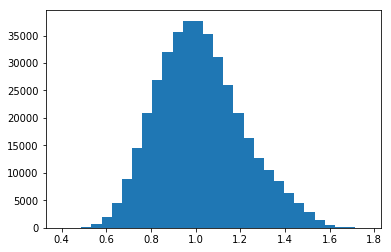

In [29]:
plt.hist(mi_genes.values(), bins=30);

In [30]:
max(mi_genes.values())

1.7597538038439293

# Genes with High Values of MI

In [ ]:
nbins=50
plt.hist(df['TXNIP_3057'].values, bins=nbins, alpha=.5);
plt.hist(df['GAPDH_6672'].values, bins=nbins,alpha=.5);

In [ ]:
plt.hist2d(df['TXNIP_3057'].values.astype('float'), df['GAPDH_6672'].values.astype('float'), bins=100);

# Genes with Low Values of MI

In [ ]:
nbins=25
plt.hist(df['SPECC1_8065'].values, bins=nbins, alpha=.5);
plt.hist(df['EPS15_1637'].values, bins=nbins,alpha=.5);
pearsonr(df['SPECC1_8065'].values, df['EPS15_1637'].values)[0]

In [ ]:
from matplotlib.colors import LogNorm
plt.hist2d(df['SPECC1_8065'].values.astype('float'), df['EPS15_1637'].values.astype('float'),norm=LogNorm(), bins=25);

In [ ]:
nbins=25
plt.hist(df['HLA-DRA_5330'].values, bins=nbins, alpha=.5);
plt.hist(df['TXNIP_3057'].values, bins=nbins,alpha=.5);

In [ ]:
plt.hist2d(df['TXNIP_3057'].values.astype('float'), df['HLA-DRA_5330'].values.astype('float'), bins=25);

In [ ]:
for g in mi_genes:
    if mi_genes[g] < .1:
        print g, mi_genes[g]

In [ ]:
for g in mi_genes:
    if mi_genes[g] > 1.7:
        print g, mi_genes[g]

In [85]:
mi_corr

{'MTRNR2L1_22884__MTRNR2L2_6347': 0.91575079609951682,
 'NACA2_16179__NACA_6238': 1.1748893112482683,
 'RPL23P8_22973__RPL23_1895': 1.2250483640087932}

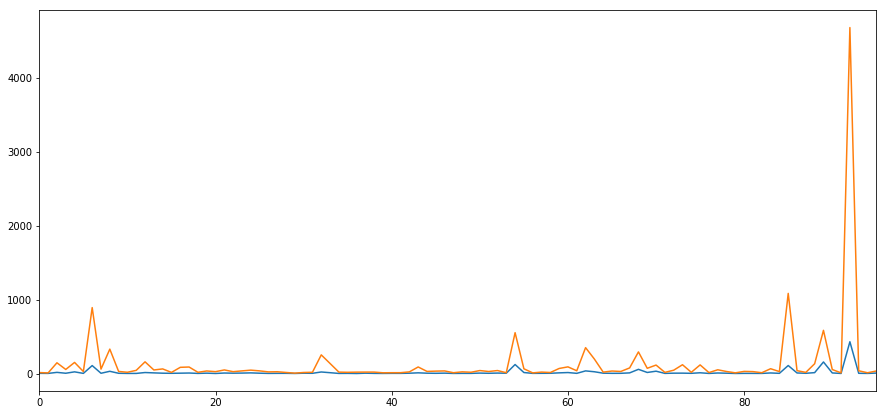

In [190]:
df['MTRNR2L1_22884'].multiply(1).plot(figsize=(15,7));
df['MTRNR2L2_6347'].plot(figsize=(15,7));

In [315]:
a = [0,0,0,0,0,1,2]
b = [1,2,0,0,0,0,0]

In [316]:
pearsonr(b,a)

(-0.34615384615384615, 0.44691561945013086)

In [317]:
calc_MI(a,b)

0.1175469692929314

In [159]:
np.var(a)

0.0024749999999999993

In [160]:
np.var(b)


0.0

In [177]:
np.sum(a > 0)


1